# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-s4iyne59
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-s4iyne59
  Resolved https://github.com/huggingface/transformers to commit 2c0af41ce5c448f872f3222a75f56030fb2e5a88
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 10.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.55.0.dev0-py3-none-any.whl size=12136384 sha256=2bb6a5931f1d78f78f3d4a16f2f665b24fc4913e72bf130c8ca989ee866e5cbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_u53ay6/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:


# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-07-31 18:58:08.828368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753988288.985796      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753988289.031509      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME = "gpt2"
BATCH_SIZE = 8
MAX_SEQ_LENGTH = 512
IMAGE_SIZE = 224

# Data Split Params
VALID_SIZE = 0.10
TEST_SIZE = 0.10
RANDOM_STATE = 42

In [6]:
def clean_text(text):
    if text is None:
        return ""
    # More comprehensive text cleaning for medical reports
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    # Remove multiple spaces
    text = ' '.join(text.split())
    return text

def create_data_manifest(xml_dir, img_dir):
    """
    Scans XMLs to create a list of all (image_path, report_text) pairs.
    Handles report duplication for multiple images.
    """
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text = clean_text(findings_node.text if findings_node is not None else "")
            full_report = f"findings: {findings_text} impression: {impression_text}"

            if not full_report.strip() or (not findings_text and not impression_text):
                continue
            
            image_nodes = root.findall(".//parentImage")
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    manifest.append({
                        'image_path': image_path,
                        'report_text': full_report
                    })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
            
    return manifest

In [7]:
class IUXRayDataset(Dataset):
    """
    PyTorch Dataset for the IU X-Ray data.
    Processes data on-the-fly.
    """
    def __init__(self, manifest, tokenizer, image_transform):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_path = item['image_path']

        # --- Process Image ---
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)

        # --- Process Text (WITHOUT PADDING) ---
        tokenized_report = self.tokenizer(
            report_text,
            truncation=True, # Still truncate long reports
            max_length=512   # Use the global max length for truncation
        )

        # The model needs 'labels' for calculating loss.
        # Typically, labels are just a copy of the input_ids.
        input_ids = tokenized_report['input_ids']
        labels = input_ids.copy()

        return {
            "image": image_tensor,
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels) # Add labels for training
        }

In [8]:
def custom_collate_fn(batch):
    """
    Custom collate function to dynamically pad the text sequences in a batch.
    """
    # 1. Separate images and text data
    images = [item['image'] for item in batch]
    input_ids_list = [item['input_ids'] for item in batch]
    labels_list = [item['labels'] for item in batch]

    # 2. Stack images into a single tensor
    images = torch.stack(images, dim=0)

    # 3. Pad the text sequences (input_ids and labels)
    # The tokenizer handles padding, creating an attention mask, and converting to tensors.
    padded_inputs = tokenizer.pad(
        {'input_ids': input_ids_list},
        padding='longest', # Pad to the longest sequence in this batch
        return_tensors='pt'
    )

    padded_labels = tokenizer.pad(
        {'input_ids': labels_list},
        padding='longest',
        return_tensors='pt'
    )['input_ids'] # We only need the input_ids from the labels padding

    # 4. An important step for loss calculation:
    # Replace the padding token id in labels with -100
    pad_token_id = tokenizer.pad_token_id
    padded_labels[padded_labels == pad_token_id] = -100

    return {
        'image': images,
        'input_ids': padded_inputs['input_ids'],
        'attention_mask': padded_inputs['attention_mask'],
        'labels': padded_labels
    }

# **Loaded Data Visualization**

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:32<00:00, 122.06it/s]


Data successfully split:
Total samples: 7430
Training set:  5944 samples
Validation set: 743 samples
Test set:      743 samples

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


Batch keys: dict_keys(['image', 'input_ids', 'attention_mask', 'labels'])
Image tensor shape:      torch.Size([8, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 80])
Attention mask shape:    torch.Size([8, 80])
Labels tensor shape:       torch.Size([8, 80])


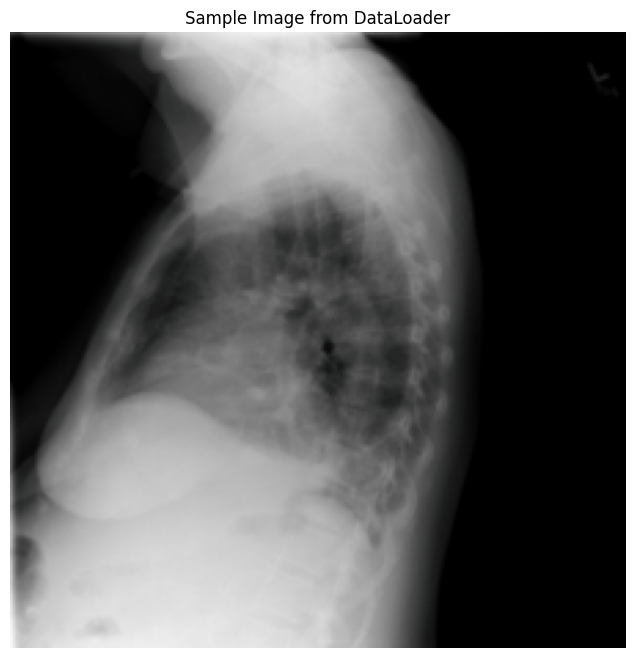


--- Sample Report from the same item (Decoded from Tensors) ---
findings:  impression: mild cardiomegaly. densely calcified aorta. prominence of the pulmonary outflow and most indicates enlarged pulmonary arteries and raise concern for pulmonary artery hypertension. there is no overt edema. the right diaphragm is elevated, there are small right and left pleural effusions. no pneumothorax.
--------------------------------------------------


In [9]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH)


train_manifest, temp_manifest = train_test_split(
    full_manifest, 
    test_size=(VALID_SIZE + TEST_SIZE), 
    random_state=RANDOM_STATE
)

val_manifest, test_manifest = train_test_split(
    temp_manifest,
    test_size=(TEST_SIZE / (VALID_SIZE + TEST_SIZE)),
    random_state=RANDOM_STATE
)

print(f"\nData successfully split:")
print(f"Total samples: {len(full_manifest)}")
print(f"Training set:  {len(train_manifest)} samples")
print(f"Validation set: {len(val_manifest)} samples")
print(f"Test set:      {len(test_manifest)} samples")

# --- 3. Create Datasets and DataLoaders ---
train_dataset = IUXRayDataset(train_manifest, tokenizer, image_transform)
val_dataset = IUXRayDataset(val_manifest, tokenizer, image_transform)
test_dataset = IUXRayDataset(test_manifest, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,collate_fn=custom_collate_fn)



print("\nPyTorch DataLoaders are ready!")

print("\n--- Verifying a sample batch from the train_loader ---")

# Fetch one batch
sample_batch = next(iter(train_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['image'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:       {sample_batch['labels'].shape}") # Added for labels

# Visualize one random item from the batch
# Ensure BATCH_SIZE is defined in your script
idx_to_show = random.randint(0, sample_batch['image'].size(0) - 1)

# --- Decode the report text from input_ids ---
# This is the new way to get the report text for visualization
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)

# --- Reverse the normalization for image display ---
img_tensor = sample_batch['image'][idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_display = (img_tensor * std) + mean
img_display = transforms.ToPILImage()(img_display)

# --- Plot the results ---
plt.figure(figsize=(8, 8))
plt.imshow(img_display)
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

print("\n--- Sample Report from the same item (Decoded from Tensors) ---")
print(report_display)
print("-" * 50)

# **MambaVision**

In [10]:
import torch
import torch.nn as nn
from transformers import AutoModel
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
import cv2

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.model.eval()
        self.device = device
        self.input_resolution = (3, 224, 224)
        

    def forward(self, image_tensor):
        """
        Input: image_tensor (B, 3, H, W) or list of PIL images
        Output: pooled features (B, 640), raw stage features
        """
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            pooled, features = self.model(image_tensor)
        return pooled, features  # (B, 640), List of [B, C, H, W]

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

Pooled feature shape: torch.Size([8, 640])
Stage 4 feature map shape: torch.Size([8, 640, 7, 7])


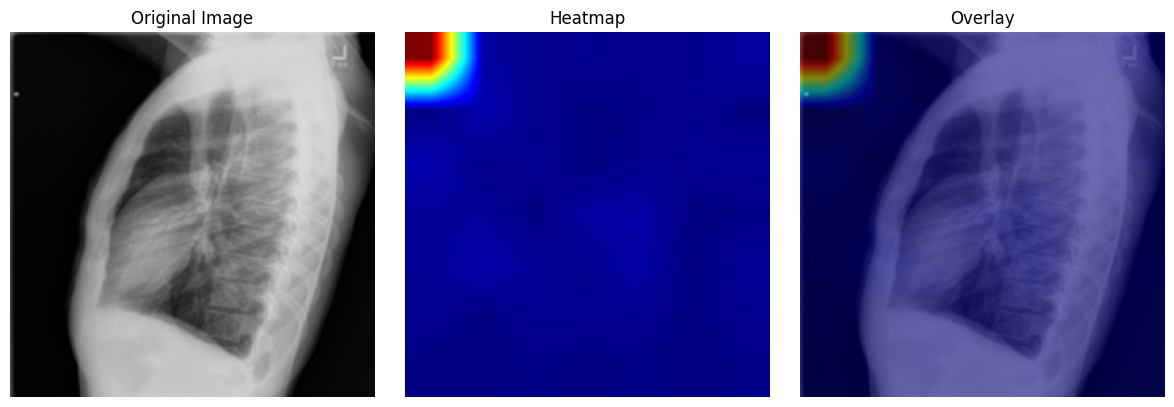

In [11]:

# === Instantiate encoder ===
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)
print(f"Stage 4 feature map shape: {stage_feats[3].shape}")  # (B, 640, 7, 7)

# === Visualize one image with heatmap overlay ===
idx = 0
image_tensor = images[idx].cpu()
feature_map = stage_feats[3][idx]  # (640, 7, 7)

# === Generate heatmap ===
activation_map = feature_map.mean(0).cpu().numpy()  # (7, 7)
activation_map = np.maximum(activation_map, 0)
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
activation_map = cv2.resize(activation_map, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# === Unnormalize image for visualization ===
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = (image_tensor * std) + mean
img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
img = np.uint8(255 * img)

# === Overlay heatmap ===
overlay = np.uint8(0.5 * img + 0.5 * heatmap)

# === Display ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

# **Projection layer**

In [12]:
import torch.nn as nn

class VisualProjection(nn.Module):
    def __init__(self, vision_dim=640, gpt2_emb_dim=768):
        super().__init__()
        self.proj = nn.Linear(vision_dim, gpt2_emb_dim)

    def forward(self, vision_feat):
        """
        vision_feat: Tensor of shape (B, vision_dim)
        Returns: Tensor of shape (B, gpt2_emb_dim)
        """
        return self.proj(vision_feat)


In [13]:
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)  # pooled_feats: (B, 640)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)

# === Instantiate Projection Layer ===
gpt2_emb_dim = 768  # or tokenizer/model config n_embd
proj_layer = VisualProjection(vision_dim=pooled_feats.shape[1], gpt2_emb_dim=gpt2_emb_dim).to('cuda')

# === Project visual features ===
with torch.no_grad():
    projected_feats = proj_layer(pooled_feats)  # (B, 768)

print(f"Projected feature shape: {projected_feats.shape}")  # (B, 768)

Pooled feature shape: torch.Size([8, 640])
Projected feature shape: torch.Size([8, 768])


# **CustomGPT2**

In [14]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [15]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [16]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [17]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

# **Main GPT2 Block**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

class CustomGPT2LM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.emb_dropout)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)

    def forward(self, input_ids, encoder_hidden_states=None, attention_mask=None, labels=None):
        b, t = input_ids.size()
        device = input_ids.device
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0).expand(b, t)
        x = self.wte(input_ids) + self.wpe(pos)
        x = self.drop(x)

        for block in self.blocks:
            x = block(x, encoder_hidden_states)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100 # Change to your tokenizer's pad_token_id if it's not 0!
            )
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            return SimpleNamespace(logits=logits)


# **Main Block**

In [19]:
import torch
import torch.nn as nn

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2):
        super().__init__()
        self.vision_encoder = vision_encoder    # MambaVisionEncoder
        self.proj_layer = proj_layer            # VisualProjection
        self.gpt2 = custom_gpt2                 # Your custom GPT-2, built from GPT2Block

    def forward(self, images, input_ids, attention_mask=None, labels=None):
        # 1. Vision feature extraction
        pooled_feats, _ = self.vision_encoder(images)           # (B, vision_dim)
        visual_emb = self.proj_layer(pooled_feats).unsqueeze(1) # (B, 1, gpt2_emb_dim)

        # 2. Pass to your custom GPT-2 model as cross-attention memory
        #    Assumes that your model's forward signature matches this usage
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels
        )
        return outputs  # outputs can include logits, loss, etc.
    def freeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

    def unfreeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = True

    def freeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = False

    def unfreeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = True

    def freeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = False

    def unfreeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, gpt2_config, custom_gpt2_class):
        """
        - vision_encoder: your vision encoder instance
        - proj_layer: your projection layer instance
        - gpt2_config: config for your custom GPT2 (define embed size etc.)
        - custom_gpt2_class: pass your custom GPT2 model class (e.g., MyCustomGPT2)
        """
        # Instantiate custom GPT-2 model
        custom_gpt2 = custom_gpt2_class(gpt2_config)

        # Load HuggingFace GPT-2 weights into your custom model
        from transformers import GPT2LMHeadModel
        hf_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        hf_sd = hf_gpt2.state_dict()
        custom_sd = custom_gpt2.state_dict()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        ignore_matches = ["cross_attn.", "ln_3"]  # keys absent/present only in your custom version

        for k in hf_sd.keys():
            if any(match in k for match in ignore_matches):
                continue
            if k not in custom_sd:
                continue
            # Transpose if needed
            if any(k.endswith(w) for w in transposed):
                if hf_sd[k].shape[::-1] == custom_sd[k].shape:
                    with torch.no_grad():
                        custom_sd[k].copy_(hf_sd[k].t())
            elif hf_sd[k].shape == custom_sd[k].shape:
                with torch.no_grad():
                    custom_sd[k].copy_(hf_sd[k])
        custom_gpt2.load_state_dict(custom_sd, strict=False)

        return cls(vision_encoder, proj_layer, custom_gpt2)


# **Trainer Class**

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image

class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        """
        vl_model: VisionLanguageWrapper instance (integrates vision encoder, projection, custom GPT2)
        tokenizer: your tokenizer (must have .bos_token_id and .eos_token_id)
        train_config: SimpleNamespace/args for training params (epochs, device, lr, batch_size, etc.)
        dls: tuple of (train_dataloader, val_dataloader)
        """
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device

        self.train_dl, self.val_dl = dls
        total_steps = len(self.train_dl)

        self.scaler = torch.cuda.amp.GradScaler()
        self.optim = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.vl_model.parameters()),
            lr=train_config.lr / 25.
        )
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=train_config.lr,
            epochs=train_config.epochs,
            steps_per_epoch=total_steps
        )

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.vl_model.state_dict()
        torch.save(sd, self.train_config.model_path / 'vl_model.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt')
        self.vl_model.load_state_dict(sd)
    def load_model_from_path(self, checkpoint_path):
        sd = torch.load(checkpoint_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)


    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        total_batches = len(self.train_dl)
        for batch_idx, batch in enumerate(self.train_dl):
            images = batch['image'].to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs  # If forward returns just loss

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()
            self.sched.step()
            self.optim.zero_grad(set_to_none=True)

            running_loss += loss.item()
            del images, input_ids, labels, loss

        train_loss = running_loss / total_batches
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Perplexity: {train_pxp:.4f}")

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        total_batches = len(self.val_dl)
        for batch_idx, batch in enumerate(self.val_dl):
            images = batch['image'].to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs

            running_loss += loss.item()
            del images, input_ids, labels, loss

        val_loss = running_loss / total_batches
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1} | Valid Loss: {val_loss:.4f} | Perplexity: {val_pxp:.4f}")
        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        for epoch in prog:
            # Stage-wise freezing/unfreezing
            if epoch == getattr(self.train_config, 'freeze_epochs_gpt', None):
                self.vl_model.unfreeze_text_decoder()
                print('Unfreezing GPT-2 decoder...')
            if epoch == getattr(self.train_config, 'freeze_epochs_all', None):
                self.vl_model.unfreeze_vision_encoder()
                self.vl_model.unfreeze_projection()
                print('Unfreezing vision encoder and projection...')

            self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()
            print(self.metrics.tail(1))

            if val_pxp < best_pxp:
                best_pxp = val_pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }

    @torch.no_grad()
    def robust_generate_radiology_report(
        self,
        image_input,             # file path or PIL.Image
        max_tokens=120,
        temperature=1.0,
        temperature_range=None,  # e.g., (0.7, 1.1), for random temp if desired
        deterministic=False,
        show_image=False,
    ):
        """
        Generate a radiology report from an image input.
        Supports image path or PIL image. Uses random temperature if a range is given.
        Optionally displays the image.
        """
        model = self.vl_model
        tokenizer = self.tokenizer
        device = self.device

        model.eval()

        # Load and optionally show the image
        if isinstance(image_input, (str, bytes, os.PathLike)):
            image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, Image.Image):
            image = image_input.convert('RGB')
        else:
            raise ValueError("image_input should be a PIL.Image or path string.")

        if show_image:
            plt.imshow(image)
            plt.axis('off')
            plt.show()

        # Preprocessing
        if hasattr(self, 'gen_tfms'):
            img_np = np.array(image)
            img_pp = self.gen_tfms(image=img_np)['image']
        else:
            from torchvision import transforms
            transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
            ])
            img_pp = transform(image)
        img_pp = img_pp.unsqueeze(0).to(device)

        # BOS token start
        sequence = torch.ones(1, 1, dtype=torch.long, device=device) * tokenizer.bos_token_id

        # If temperature_range requested, sample temperature
        if temperature_range is not None and not deterministic:
            temperature = np.random.uniform(*temperature_range)

        for _ in range(max_tokens):
            with torch.no_grad():
                pooled_feats, _ = model.vision_encoder(img_pp)
                visual_emb = model.proj_layer(pooled_feats).unsqueeze(1)
                out = model.gpt2(
                    sequence,
                    encoder_hidden_states=visual_emb
                ).logits
                logits = out[:, -1, :] / temperature
                probs = torch.softmax(logits, dim=-1)
                if deterministic:
                    next_token = torch.argmax(probs, dim=-1, keepdim=True)
                else:
                    next_token = torch.multinomial(probs, num_samples=1)
                sequence = torch.cat([sequence, next_token], dim=1)
                if next_token.item() == tokenizer.eos_token_id:
                    break

        report = tokenizer.decode(sequence[0].tolist(), skip_special_tokens=True)
        return report



In [21]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)

# Training-related configuration
train_config = SimpleNamespace(
    epochs = 50,
    freeze_epochs_gpt = 25,       # Unfreeze GPT-2 at epoch 1
    freeze_epochs_all = 30,       # Unfreeze vision encoder/proj at epoch 2
    lr = 2e-5,
    device = 'cuda',
    model_path = Path('vl_captioner'),   # Output directory for checkpoints
    batch_size = 8
)


In [22]:
# --- Tokenizer ---
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# --- Model components ---
# Assume you have already defined MambaVisionEncoder, VisualProjection, and your custom GPT-2 model class (e.g., CustomGPT2Model)
vision_encoder = MambaVisionEncoder().to(train_config.device)
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

# Build VisionLanguageWrapper using your from_pretrained logic
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder,
    proj_layer,
    model_config,
    CustomGPT2LM
).to(train_config.device)

# --- Trainer ---
# Assume you already have train_dataloader and val_dataloader prepared as PyTorch DataLoader instances
trainer = Trainer(
    vl_model,                      # your VisionLanguageWrapper instance
    tokenizer,                     # your GPT-2 tokenizer
    train_config,                  # your training config (SimpleNamespace)
    (train_loader, val_loader)  # tuple of your dataloaders
)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/tmp/ipykernel_19/921853448.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [23]:
trainer.fit()

  0%|          | 0/50 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 7.4825 | Perplexity: 1776.7208


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Valid Loss: 4.4912 | Perplexity: 89.2326
  train_loss train_perplexity  val_loss val_perplexity
0   7.482525      1776.720769  4.491246      89.232603
Saving best model...


  2%|▏         | 1/50 [03:28<2:50:26, 208.69s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Train Loss: 4.1960 | Perplexity: 66.4225


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Valid Loss: 3.3619 | Perplexity: 28.8443
  train_loss train_perplexity  val_loss val_perplexity
1   4.196036        66.422524  3.361913      28.844312
Saving best model...


  4%|▍         | 2/50 [06:53<2:45:19, 206.66s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Train Loss: 3.3105 | Perplexity: 27.3978


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Valid Loss: 2.7500 | Perplexity: 15.6427
  train_loss train_perplexity  val_loss val_perplexity
2   3.310463        27.397804  2.750005       15.64271
Saving best model...


  6%|▌         | 3/50 [10:19<2:41:26, 206.09s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Train Loss: 2.7305 | Perplexity: 15.3401


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Valid Loss: 2.3145 | Perplexity: 10.1200
  train_loss train_perplexity val_loss val_perplexity
3   2.730473        15.340139  2.31451      10.119961
Saving best model...


  8%|▊         | 4/50 [13:45<2:38:06, 206.22s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Train Loss: 2.3277 | Perplexity: 10.2540


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Valid Loss: 2.0188 | Perplexity: 7.5289
  train_loss train_perplexity  val_loss val_perplexity
4    2.32767        10.254022  2.018755       7.528944
Saving best model...


 10%|█         | 5/50 [17:12<2:34:51, 206.48s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Train Loss: 2.0468 | Perplexity: 7.7432


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Valid Loss: 1.8080 | Perplexity: 6.0985
  train_loss train_perplexity  val_loss val_perplexity
5   2.046818         7.743223  1.808046       6.098521
Saving best model...


 12%|█▏        | 6/50 [20:39<2:31:30, 206.61s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Train Loss: 1.8292 | Perplexity: 6.2289


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Valid Loss: 1.6540 | Perplexity: 5.2278
  train_loss train_perplexity  val_loss val_perplexity
6   1.829202         6.228916  1.653984       5.227766
Saving best model...


 14%|█▍        | 7/50 [24:04<2:27:39, 206.04s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Train Loss: 1.6508 | Perplexity: 5.2111


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Valid Loss: 1.5152 | Perplexity: 4.5504
  train_loss train_perplexity  val_loss val_perplexity
7   1.650782         5.211055  1.515217       4.550408
Saving best model...


 16%|█▌        | 8/50 [27:30<2:24:08, 205.92s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Train Loss: 1.5002 | Perplexity: 4.4826


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Valid Loss: 1.4081 | Perplexity: 4.0882
  train_loss train_perplexity  val_loss val_perplexity
8     1.5002         4.482587  1.408093       4.088153
Saving best model...


 18%|█▊        | 9/50 [30:56<2:20:47, 206.03s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Train Loss: 1.3660 | Perplexity: 3.9198


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Valid Loss: 1.3130 | Perplexity: 3.7171
  train_loss train_perplexity  val_loss val_perplexity
9   1.366039         3.919794  1.312954       3.717139
Saving best model...


 20%|██        | 10/50 [34:22<2:17:24, 206.12s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 | Train Loss: 1.2448 | Perplexity: 3.4723


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 | Valid Loss: 1.2240 | Perplexity: 3.4007
   train_loss train_perplexity  val_loss val_perplexity
10   1.244808         3.472268  1.223968       3.400655
Saving best model...


 22%|██▏       | 11/50 [37:48<2:13:49, 205.88s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12 | Train Loss: 1.1319 | Perplexity: 3.1015


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12 | Valid Loss: 1.1502 | Perplexity: 3.1589
   train_loss train_perplexity  val_loss val_perplexity
11   1.131898         3.101538  1.150225       3.158905
Saving best model...


 24%|██▍       | 12/50 [41:13<2:10:22, 205.86s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 | Train Loss: 1.0291 | Perplexity: 2.7985


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 | Valid Loss: 1.0796 | Perplexity: 2.9436
   train_loss train_perplexity  val_loss val_perplexity
12   1.029081         2.798493  1.079647       2.943641
Saving best model...


 26%|██▌       | 13/50 [44:40<2:07:04, 206.08s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14 | Train Loss: 0.9269 | Perplexity: 2.5267


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14 | Valid Loss: 1.0154 | Perplexity: 2.7605
   train_loss train_perplexity  val_loss val_perplexity
13   0.926913         2.526697  1.015405       2.760482
Saving best model...


 28%|██▊       | 14/50 [48:06<2:03:38, 206.07s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15 | Train Loss: 0.8326 | Perplexity: 2.2993


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15 | Valid Loss: 0.9585 | Perplexity: 2.6077
   train_loss train_perplexity  val_loss val_perplexity
14   0.832619         2.299333  0.958483       2.607737
Saving best model...


 30%|███       | 15/50 [51:31<2:00:04, 205.84s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16 | Train Loss: 0.7484 | Perplexity: 2.1137


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16 | Valid Loss: 0.8929 | Perplexity: 2.4423
   train_loss train_perplexity  val_loss val_perplexity
15   0.748429         2.113677  0.892936       2.442289
Saving best model...


 32%|███▏      | 16/50 [54:55<1:56:21, 205.34s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17 | Train Loss: 0.6688 | Perplexity: 1.9519


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17 | Valid Loss: 0.8572 | Perplexity: 2.3566
   train_loss train_perplexity  val_loss val_perplexity
16   0.668812         1.951917  0.857209       2.356575
Saving best model...


 34%|███▍      | 17/50 [58:23<1:53:20, 206.07s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18 | Train Loss: 0.5952 | Perplexity: 1.8133


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18 | Valid Loss: 0.7882 | Perplexity: 2.1994
   train_loss train_perplexity  val_loss val_perplexity
17   0.595153         1.813308  0.788175        2.19938
Saving best model...


 36%|███▌      | 18/50 [1:01:49<1:49:54, 206.09s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19 | Train Loss: 0.5345 | Perplexity: 1.7066


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19 | Valid Loss: 0.7479 | Perplexity: 2.1126
   train_loss train_perplexity val_loss val_perplexity
18    0.53452         1.706629  0.74793       2.112622
Saving best model...


 38%|███▊      | 19/50 [1:05:15<1:46:27, 206.03s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20 | Train Loss: 0.4780 | Perplexity: 1.6129


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20 | Valid Loss: 0.7019 | Perplexity: 2.0177
   train_loss train_perplexity  val_loss val_perplexity
19   0.478003          1.61285  0.701944       2.017672
Saving best model...


 40%|████      | 20/50 [1:08:39<1:42:37, 205.24s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21 | Train Loss: 0.4320 | Perplexity: 1.5403


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21 | Valid Loss: 0.6642 | Perplexity: 1.9429
   train_loss train_perplexity  val_loss val_perplexity
20   0.431981         1.540305  0.664184       1.942904
Saving best model...


 42%|████▏     | 21/50 [1:12:05<1:39:17, 205.44s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22 | Train Loss: 0.3883 | Perplexity: 1.4745


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22 | Valid Loss: 0.6297 | Perplexity: 1.8770
   train_loss train_perplexity  val_loss val_perplexity
21   0.388326          1.47451  0.629674       1.876998
Saving best model...


 44%|████▍     | 22/50 [1:15:30<1:35:55, 205.55s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23 | Train Loss: 0.3533 | Perplexity: 1.4238


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23 | Valid Loss: 0.6047 | Perplexity: 1.8308
   train_loss train_perplexity  val_loss val_perplexity
22   0.353329           1.4238  0.604741       1.830778
Saving best model...


 46%|████▌     | 23/50 [1:18:57<1:32:36, 205.78s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24 | Train Loss: 0.3238 | Perplexity: 1.3824


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24 | Valid Loss: 0.5825 | Perplexity: 1.7906
   train_loss train_perplexity  val_loss val_perplexity
23     0.3238          1.38237  0.582544       1.790588
Saving best model...


 48%|████▊     | 24/50 [1:22:23<1:29:16, 206.02s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25 | Train Loss: 0.2973 | Perplexity: 1.3462


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25 | Valid Loss: 0.5621 | Perplexity: 1.7544
   train_loss train_perplexity  val_loss val_perplexity
24   0.297277         1.346188  0.562144        1.75443
Saving best model...


 50%|█████     | 25/50 [1:25:49<1:25:45, 205.81s/it]

Unfreezing GPT-2 decoder...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 26 | Train Loss: 0.2773 | Perplexity: 1.3195


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 26 | Valid Loss: 0.5492 | Perplexity: 1.7318
   train_loss train_perplexity  val_loss val_perplexity
25   0.277283          1.31954  0.549166       1.731808
Saving best model...


 52%|█████▏    | 26/50 [1:29:15<1:22:25, 206.07s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 27 | Train Loss: 0.2591 | Perplexity: 1.2958


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 27 | Valid Loss: 0.5432 | Perplexity: 1.7216
   train_loss train_perplexity  val_loss val_perplexity
26   0.259139         1.295813  0.543242       1.721579
Saving best model...


 54%|█████▍    | 27/50 [1:32:40<1:18:50, 205.67s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 28 | Train Loss: 0.2423 | Perplexity: 1.2742


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 28 | Valid Loss: 0.5332 | Perplexity: 1.7044
   train_loss train_perplexity  val_loss val_perplexity
27   0.242347         1.274237  0.533207        1.70439
Saving best model...


 56%|█████▌    | 28/50 [1:36:06<1:15:26, 205.75s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 29 | Train Loss: 0.2284 | Perplexity: 1.2566


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 29 | Valid Loss: 0.5245 | Perplexity: 1.6896
   train_loss train_perplexity  val_loss val_perplexity
28   0.228432         1.256628  0.524481       1.689581
Saving best model...


 58%|█████▊    | 29/50 [1:39:30<1:11:48, 205.15s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 30 | Train Loss: 0.2180 | Perplexity: 1.2436


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 30 | Valid Loss: 0.5244 | Perplexity: 1.6895
   train_loss train_perplexity  val_loss val_perplexity
29   0.218019         1.243611  0.524429       1.689494
Saving best model...


 60%|██████    | 30/50 [1:42:56<1:08:28, 205.41s/it]

Unfreezing vision encoder and projection...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 31 | Train Loss: 0.2078 | Perplexity: 1.2310


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 31 | Valid Loss: 0.5225 | Perplexity: 1.6862
   train_loss train_perplexity  val_loss val_perplexity
30   0.207802         1.230969  0.522461       1.686172
Saving best model...


 62%|██████▏   | 31/50 [1:46:22<1:05:05, 205.53s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 32 | Train Loss: 0.1993 | Perplexity: 1.2206


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 32 | Valid Loss: 0.5228 | Perplexity: 1.6867


 64%|██████▍   | 32/50 [1:49:46<1:01:34, 205.23s/it]

   train_loss train_perplexity  val_loss val_perplexity
31   0.199309         1.220559  0.522772       1.686697


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 33 | Train Loss: 0.1925 | Perplexity: 1.2123


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 33 | Valid Loss: 0.5241 | Perplexity: 1.6889


 66%|██████▌   | 33/50 [1:53:08<57:54, 204.37s/it]  

   train_loss train_perplexity  val_loss val_perplexity
32   0.192526         1.212308  0.524082       1.688907


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 34 | Train Loss: 0.1852 | Perplexity: 1.2035


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 34 | Valid Loss: 0.5189 | Perplexity: 1.6802
   train_loss train_perplexity val_loss val_perplexity
33   0.185206         1.203466  0.51893       1.680229
Saving best model...


 68%|██████▊   | 34/50 [1:56:32<54:25, 204.08s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 35 | Train Loss: 0.1797 | Perplexity: 1.1968


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 35 | Valid Loss: 0.5164 | Perplexity: 1.6760
   train_loss train_perplexity  val_loss val_perplexity
34   0.179653         1.196802  0.516413       1.676005
Saving best model...


 70%|███████   | 35/50 [1:59:57<51:07, 204.47s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 36 | Train Loss: 0.1760 | Perplexity: 1.1924


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 36 | Valid Loss: 0.5175 | Perplexity: 1.6779


 72%|███████▏  | 36/50 [2:03:21<47:38, 204.18s/it]

   train_loss train_perplexity  val_loss val_perplexity
35    0.17598         1.192414  0.517526       1.677872


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 37 | Train Loss: 0.1705 | Perplexity: 1.1859


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 37 | Valid Loss: 0.5178 | Perplexity: 1.6783


 74%|███████▍  | 37/50 [2:06:44<44:09, 203.82s/it]

   train_loss train_perplexity  val_loss val_perplexity
36   0.170512         1.185912  0.517784       1.678304


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 38 | Train Loss: 0.1662 | Perplexity: 1.1808


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 38 | Valid Loss: 0.5180 | Perplexity: 1.6787


 76%|███████▌  | 38/50 [2:10:05<40:38, 203.19s/it]

   train_loss train_perplexity val_loss val_perplexity
37   0.166195         1.180803  0.51799       1.678651


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 39 | Train Loss: 0.1627 | Perplexity: 1.1767


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 39 | Valid Loss: 0.5180 | Perplexity: 1.6786


 78%|███████▊  | 39/50 [2:13:29<37:14, 203.18s/it]

   train_loss train_perplexity  val_loss val_perplexity
38   0.162673         1.176652  0.517977       1.678629


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 40 | Train Loss: 0.1600 | Perplexity: 1.1735


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 40 | Valid Loss: 0.5168 | Perplexity: 1.6767


 80%|████████  | 40/50 [2:16:52<33:52, 203.26s/it]

   train_loss train_perplexity  val_loss val_perplexity
39   0.159969         1.173474  0.516827         1.6767


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 41 | Train Loss: 0.1568 | Perplexity: 1.1697


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 41 | Valid Loss: 0.5167 | Perplexity: 1.6765


 82%|████████▏ | 41/50 [2:20:12<30:20, 202.28s/it]

   train_loss train_perplexity val_loss val_perplexity
40   0.156776         1.169733   0.5167       1.676486


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 42 | Train Loss: 0.1548 | Perplexity: 1.1674


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 42 | Valid Loss: 0.5169 | Perplexity: 1.6769


 84%|████████▍ | 42/50 [2:23:30<26:49, 201.14s/it]

   train_loss train_perplexity  val_loss val_perplexity
41   0.154777         1.167398  0.516928       1.676868


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 43 | Train Loss: 0.1523 | Perplexity: 1.1645


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 43 | Valid Loss: 0.5187 | Perplexity: 1.6799


 86%|████████▌ | 43/50 [2:26:50<23:25, 200.79s/it]

   train_loss train_perplexity  val_loss val_perplexity
42   0.152329         1.164543  0.518705       1.679851


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 44 | Train Loss: 0.1499 | Perplexity: 1.1617


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 44 | Valid Loss: 0.5174 | Perplexity: 1.6777


 88%|████████▊ | 44/50 [2:30:09<20:00, 200.03s/it]

   train_loss train_perplexity  val_loss val_perplexity
43   0.149905         1.161723  0.517437       1.677721


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 45 | Train Loss: 0.1487 | Perplexity: 1.1603


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 45 | Valid Loss: 0.5172 | Perplexity: 1.6773


 90%|█████████ | 45/50 [2:33:26<16:36, 199.32s/it]

   train_loss train_perplexity  val_loss val_perplexity
44   0.148654         1.160271  0.517209        1.67734


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 46 | Train Loss: 0.1470 | Perplexity: 1.1584


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 46 | Valid Loss: 0.5171 | Perplexity: 1.6772


 92%|█████████▏| 46/50 [2:36:44<13:15, 198.77s/it]

   train_loss train_perplexity  val_loss val_perplexity
45   0.147033         1.158392  0.517104       1.677163


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 47 | Train Loss: 0.1464 | Perplexity: 1.1577


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 47 | Valid Loss: 0.5167 | Perplexity: 1.6765


 94%|█████████▍| 47/50 [2:40:01<09:55, 198.39s/it]

   train_loss train_perplexity  val_loss val_perplexity
46   0.146434         1.157699  0.516686       1.676463


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 48 | Train Loss: 0.1455 | Perplexity: 1.1566


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 48 | Valid Loss: 0.5164 | Perplexity: 1.6760


 96%|█████████▌| 48/50 [2:43:19<06:36, 198.22s/it]

   train_loss train_perplexity  val_loss val_perplexity
47   0.145525         1.156647  0.516432       1.676036


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 49 | Train Loss: 0.1448 | Perplexity: 1.1558


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 49 | Valid Loss: 0.5173 | Perplexity: 1.6775


 98%|█████████▊| 49/50 [2:46:37<03:18, 198.05s/it]

   train_loss train_perplexity  val_loss val_perplexity
48   0.144755         1.155756  0.517293        1.67748


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 50 | Train Loss: 0.1453 | Perplexity: 1.1563


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/921853448.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 50 | Valid Loss: 0.5170 | Perplexity: 1.6770


100%|██████████| 50/50 [2:49:55<00:00, 203.90s/it]

   train_loss train_perplexity  val_loss val_perplexity
49   0.145263         1.156343  0.517012       1.677009


{'best_perplexity': 1.6760046016041557, 'best_epoch': 34}

# **Loading Trained Model**

In [24]:
trainer.load_best_model()

In [25]:
#trainer.load_model_from_path("/kaggle/input/testing/vl_model.pt")

# **Report Genearation**

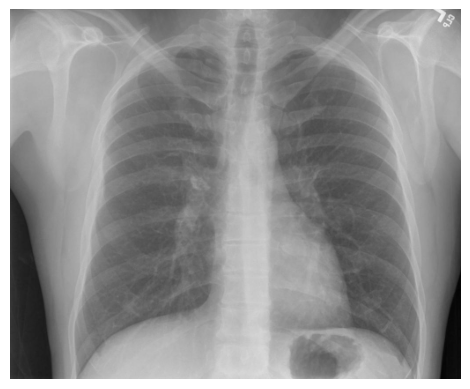

Generated report: ings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. impression: no acute disease. no acute disease. no evidence of active disease. old right shoulder. if there is no acute disease. deformities identified on the lateral view of the lateral exam. if there is no acute disease. impression: no acute disease. no acute disease. followup after appropriate treatment to document complete resolution. followup examination is recommended if none are available for further


In [26]:
report = trainer.robust_generate_radiology_report(
    image_input="/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1007_IM-0008-1001.png",
    max_tokens=100,
    temperature_range=(0.5, 1.5),
    deterministic=True,
    show_image=True
)
print("Generated report:", report)